In [51]:
using Distributions
using StatsPlots
using LaTeXStrings
using CSV
using DataFrames
using StatisticalRethinking
using LinearAlgebra
using Logging
using Random
using Turing

# setting default attributes for plots
default(label=false)
Logging.disable_logging(Logging.Warn);

# 4.1 Why normal distributions are normal

Code 4.1

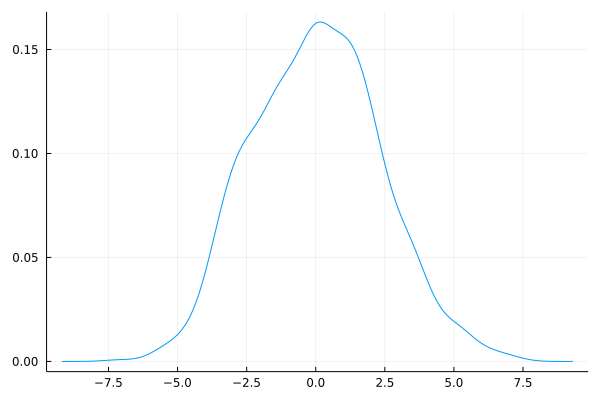

In [3]:
n = rand(Uniform(-1, 1), 1000, 16);
pos = sum.(eachrow(n));
density(pos)

Code 4.2

In [5]:
prod(1 .+ rand(Uniform(0, .1), 12))

1.7497337505551638

Code 4.3

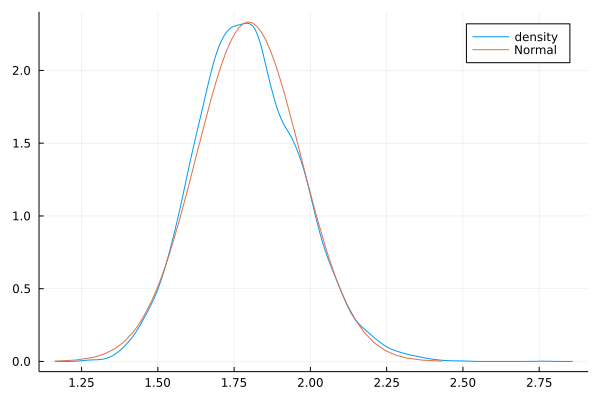

In [6]:
u = Uniform(0, .1)
growth = prod.(eachrow(1 .+ rand(u, 10000, 12)));

density(growth; label="density")
# overlay normal distribution
μ = mean(growth)
σ = std(growth)
plot!(Normal(μ, σ); label="Normal")

Code 4.4

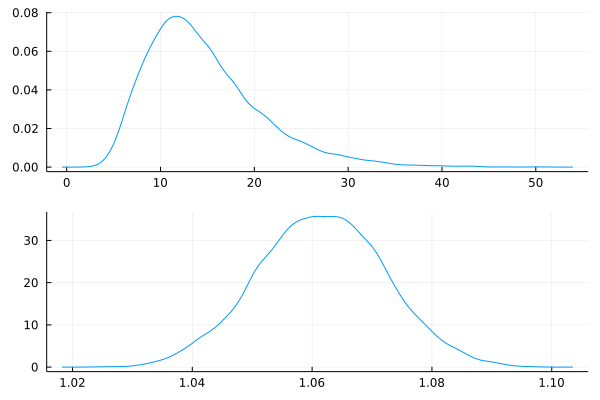

In [7]:
big = prod.(eachrow(1 .+ rand(Uniform(0, 0.5), 10000, 12)));
small = prod.(eachrow(1 .+ rand(Uniform(0, 0.01), 10000, 12)));
density([big, small]; layout=(2, 1))

Code 4.5

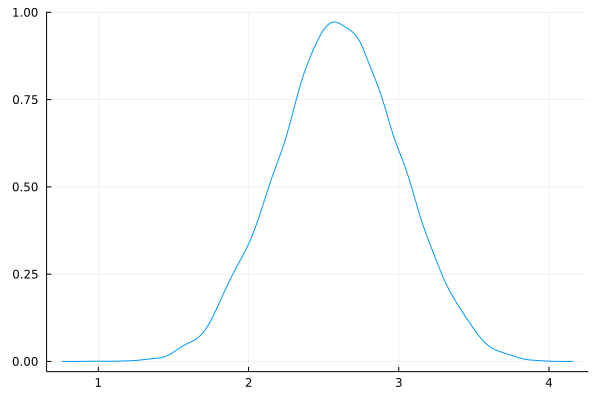

In [8]:
density(log.(big))

# 4.2 A language for describing models

Code 4.6

In [9]:
w = 6
n = 9
p_grid = range(0, 1; length=100)
bin_dens = [pdf(Binomial(n, p), w) for p in p_grid]
uni_dens = [pdf(Uniform(0, 1), p) for p in p_grid];
posterior = bin_dens .* uni_dens
posterior /= sum(posterior);

# 4.3 Gaussian model of height

Code 4.7

In [10]:
d = DataFrame(CSV.File("data/Howell1.csv"));

Code 4.8

In [11]:
describe(d)

4×7 DataFrame
 Row │ variable  mean        min       median    max       nmissing  eltype   
     │ Symbol    Float64     Real      Float64   Real      Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ height    138.264     53.975    148.59    179.07           0  Float64
   2 │ weight     35.6106     4.25242   40.0578   62.9926         0  Float64
   3 │ age        29.3444     0.0       27.0      88.0            0  Float64
   4 │ male        0.472426   0          0.0       1              0  Int64

Code 4.9

In [12]:
precis(d)

┌────────┬────────────────────────────────────────────────────────────┐
│  param │    mean      std     5.5%      50%    94.5%      histogram │
├────────┼────────────────────────────────────────────────────────────┤
│ height │ 138.264  27.6024  81.1086   148.59  165.735  ▁▁▁▂▂▂▂▂▂██▆▁ │
│ weight │ 35.6106  14.7192   9.3607  40.0578  54.5029  ▁▃▄▄▃▂▃▆██▅▃▁ │
│    age │ 29.3444  20.7469      1.0     27.0   66.135      █▆▆▆▆▃▃▁▁ │
│   male │  0.4724   0.4997      0.0      0.0      1.0    █▁▁▁▁▁▁▁▁▁█ │
└────────┴────────────────────────────────────────────────────────────┘


Code 4.10

In [13]:
d.height

544-element Vector{Float64}:
 151.765
 139.7
 136.525
 156.845
 145.415
 163.83
 149.225
 168.91
 147.955
 165.1
 154.305
 151.13
 144.78
   ⋮
 156.21
 152.4
 162.56
 114.935
  67.945
 142.875
  76.835
 145.415
 162.56
 156.21
  71.12
 158.75

Code 4.11

In [14]:
d2 = d[d.age .>= 18,:];

Code 4.12

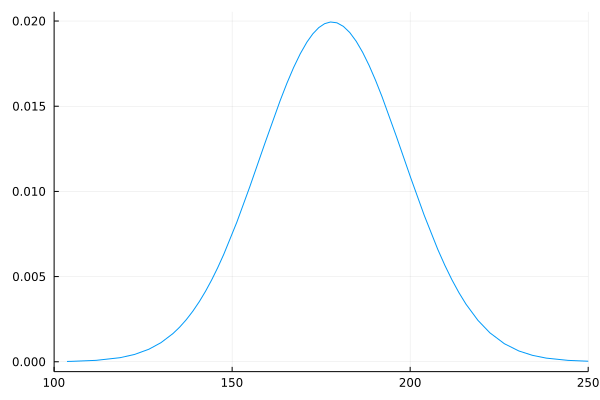

In [15]:
plot(Normal(178, 20); xlim=(100, 250))

Code 4.13

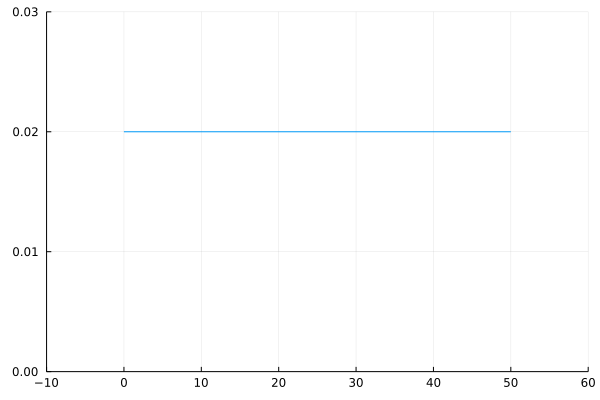

In [16]:
plot(Uniform(0, 50), xlim=(-10, 60), ylim=(0, 0.03))

Code 4.14

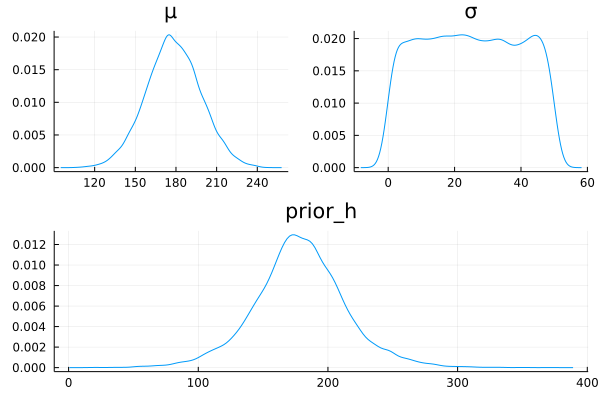

In [17]:
size = 10_000
sample_μ = rand(Normal(178, 20), size)
sample_σ = rand(Uniform(0, 50), size);
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

p1 = density(sample_μ; title="μ")
p2 = density(sample_σ; title="σ")
p3 = density(prior_h; title="prior_h")

plot(p1, p2, p3, layout=@layout [a b; c])

Code 4.15

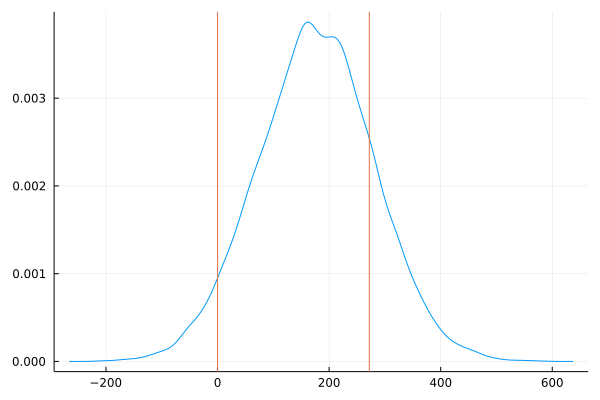

In [18]:
sample_μ = rand(Normal(178, 100), size)
prior_h = [rand(Normal(μ, σ)) for (μ, σ) in zip(sample_μ, sample_σ)];

density(prior_h)
vline!([0, 272])

Code 4.16

In [19]:
μ_list = range(150, 160; length=100)
σ_list = range(7, 9; length=100)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d2.height))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
];

max_prod = maximum(log_prod)
prob = @. exp(log_prod - max_prod);

Code 4.17

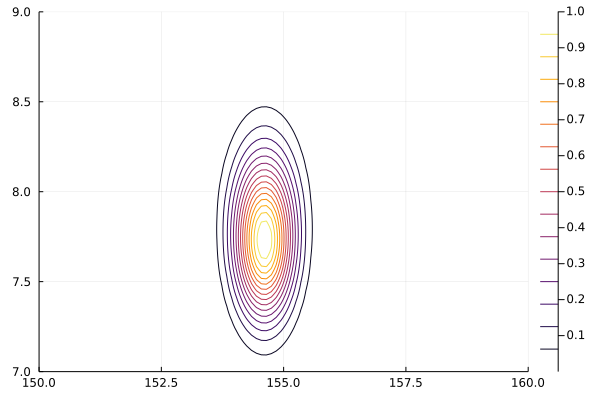

In [20]:
# note the transposition, that's due to Julia matrix order
contour(μ_list, σ_list, prob')

Code 4.18

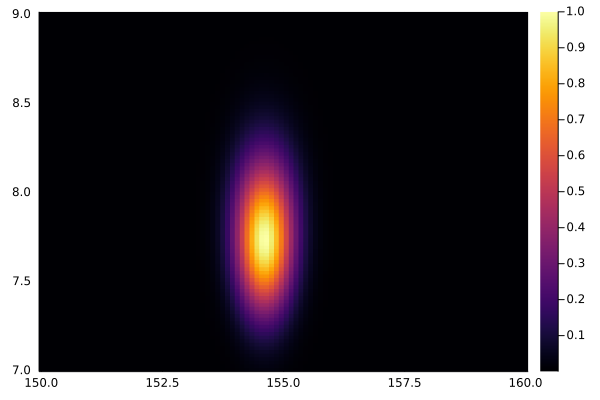

In [21]:
heatmap(μ_list, σ_list, prob')

Code 4.19

In [22]:
indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample_idx = wsample(vec(indices), vec(prob), 10_000; replace=true)
sample_μ = μ_list[first.(sample_idx)]
sample_σ = σ_list[last.(sample_idx)];

Code 4.20

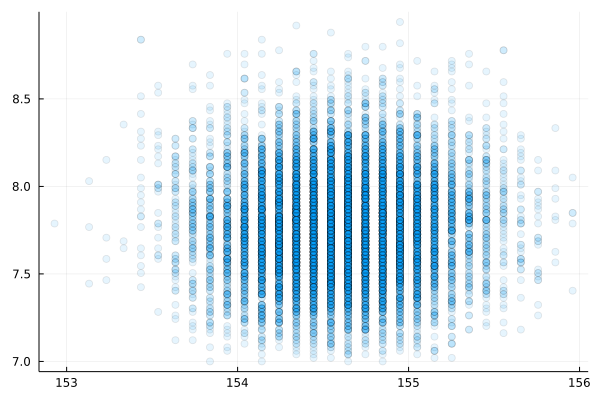

In [23]:
scatter(sample_μ, sample_σ; alpha=0.1)

Code 4.21

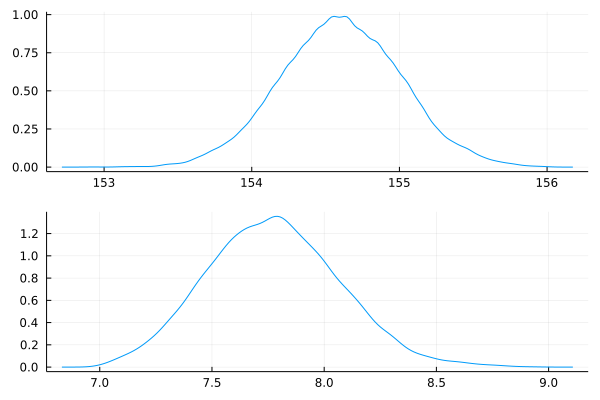

In [24]:
p1 = density(sample_μ)
p2 = density(sample_σ)
plot(p1, p2, layout=(2,1))

Code 4.22

In [25]:
println(hpdi(sample_μ, alpha=0.11))
println(hpdi(sample_σ, alpha=0.11))

[153.93939393939394, 155.15151515151516]
[7.262626262626263, 8.191919191919192]


Code 4.23

In [26]:
d3 = sample(d2.height, 20);

Code 4.24

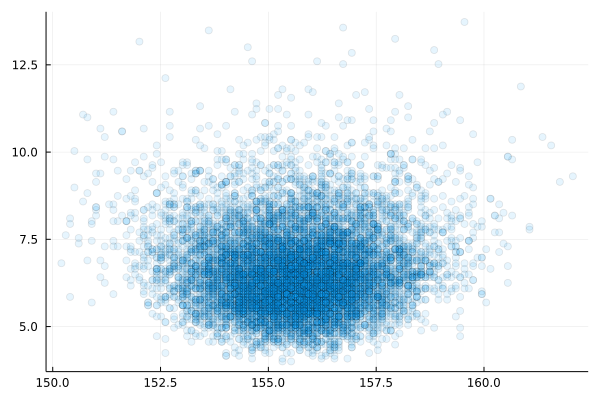

In [27]:
μ_list = range(150, 170; length=200)
σ_list = range(4, 20; length=200)

log_likelihood = [
    sum(logpdf(Normal(μ, σ), d3))
    for μ ∈ μ_list, σ ∈ σ_list
]
log_prod = log_likelihood .+ [
    logpdf(Normal(178, 20), μ) + logpdf(Uniform(0, 50), σ)
    for μ ∈ μ_list, σ ∈ σ_list
]

max_prod = maximum(log_prod)
prob2 = @. exp(log_prod - max_prod)

indices = collect(Iterators.product(1:length(μ_list), 1:length(σ_list)));
sample2_idx = wsample(vec(indices), vec(prob2), 10_000; replace=true)
sample2_μ = μ_list[first.(sample2_idx)]
sample2_σ = σ_list[last.(sample2_idx)]

scatter(sample2_μ, sample2_σ; alpha=0.1)

Code 4.25

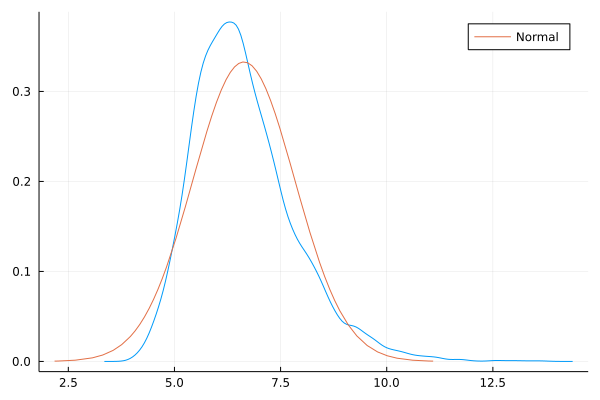

In [28]:
density(sample2_σ)
μ = mean(sample2_σ)
σ = std(sample2_σ)
plot!(Normal(μ, σ); label="Normal")

Code 4.26

In [29]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];

Code 4.27

In [30]:
@model function model_height(height)
    μ ~ Normal(178, 20)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

model_height (generic function with 2 methods)

Code 4.28

In [31]:
m4_1 = sample(model_height(d2.height), NUTS(), 1000)

Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 6.94 seconds
Compute duration  = 6.94 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   154.5908    0.3973     0.0126    0.0117   1000.5381    1.0018   ⋯
           σ     7.7626    0.2933     0.0093    0.0094   1096.5427    0.9997   ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

 

Code 4.29

In [32]:
display.(describe(m4_1; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   154.5908    0.3973     0.0126    0.0117   1000.5381    1.0018   ⋯
           σ     7.7626    0.2933     0.0093    0.0094   1096.5427    0.9997   ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   153.9399   155.2307
           σ     7.3123     8.2306


Code 4.30

In [33]:
init_vals = [mean(d2.height), std(d2.height)]
chain = sample(model_height(d2.height), NUTS(), 1000, init_theta=init_vals)

Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.64 seconds
Compute duration  = 0.64 seconds
parameters        = μ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

           μ   154.6343    0.4112     0.0130    0.0132   1026.3117    1.0007   ⋯
           σ     7.7569    0.2770     0.0088    0.0096    814.5445    1.0018   ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

 

Code 4.31

In [34]:
@model function model_height(height)
    μ ~ Normal(178, 0.1)
    σ ~ Uniform(0, 50)
    height ~ Normal(μ, σ)
end

m4_2 = sample(model_height(d2.height), NUTS(), 1000)
display.(describe(m4_2; q=[0.055, 0.945]));

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           μ   177.8698    0.0978     0.0031    0.0035   924.0312    0.9990    ⋯
           σ    24.5901    0.9585     0.0303    0.0323   878.8627    0.9993    ⋯
                                                                1 column omitted


Quantiles
  parameters       5.5%      94.5% 
      Symbol    Float64    Float64 

           μ   177.7092   178.0164
           σ    23.0857    26.1650


Code 4.32

In [35]:
cov(hcat(m4_1[:μ], m4_1[:σ]))

2×2 Matrix{Float64}:
  0.157848    -0.00415407
 -0.00415407   0.0860078

Code 4.33

In [45]:
c = cov(hcat(m4_1[:μ], m4_1[:σ]))
cov2cor(c, diag(c))

2×2 Matrix{Float64}:
  1.0       -0.305982
 -0.305982   1.0

Code 4.34

In [46]:
# resetrange is needed due to bug in MCMCChains: https://github.com/TuringLang/MCMCChains.jl/issues/324
# once it will be fixed, direct sampling from the chain will be possible
samp_chain = sample(resetrange(m4_1), 10_000)
samp_df = DataFrame(samp_chain)
first(samp_df, 5)

5×2 DataFrame
 Row │ μ        σ       
     │ Float64  Float64 
─────┼──────────────────
   1 │ 154.515  8.1209
   2 │ 154.636  7.91587
   3 │ 154.191  7.78174
   4 │ 154.646  7.15817
   5 │ 153.883  7.01272

Code 4.35

In [47]:
precis(samp_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     μ │ 154.581  0.3966  153.926  154.594  155.219  ▁▁▁▃▄▇██▇▃▂▁▁ │
│     σ │  7.7595  0.2945    7.308   7.7535   8.2268    ▁▁▃▇██▅▂▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 4.36

In [48]:
data = hcat(m4_1[:μ], m4_1[:σ])
μ = mean(data, dims=1)
σ = cov(data)
mvn = MvNormal(vec(μ), σ)
post = rand(mvn, 10_000);
print(mvn)

FullNormal(
dim: 2
μ: [154.59077949557047, 7.762550232130143]
Σ: [0.15784827244408303 -0.0041540657831509046; -0.0041540657831509046 0.0860077679821369]
)


# 4.4 Linear predictions

Code 4.37

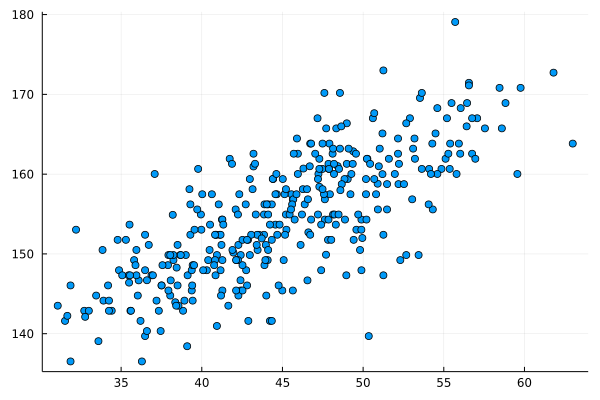

In [49]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:];
# fancy way of doing scatter(d2.weight, d2.height)
@df d2 scatter(:weight, :height)

Code 4.38

In [52]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(Normal(0, 10), N);

Code 4.39

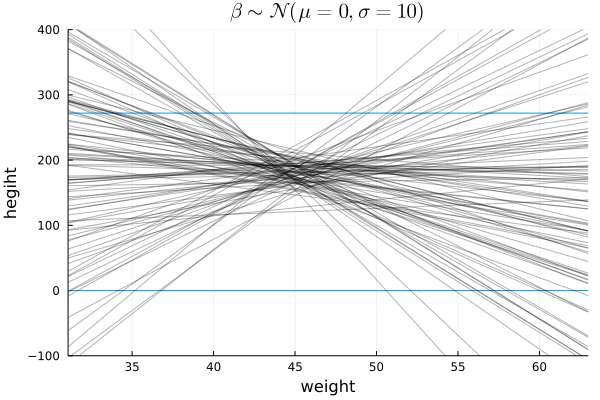

In [53]:
p = hline([0, 272]; ylims=(-100, 400), xlabel="weight", ylabel="hegiht")
title!(L"\beta \sim \mathcal{N}(\mu=0,\sigma=10)")

x_mean = mean(d2.weight)
xlims = extrema(d2.weight)  # getting min and max in one pass

for (α, β) ∈ zip(a, b)
    plot!(x -> α + β * (x - x_mean); xlims=xlims, c=:black, alpha=0.3)
end
display(p)

Code 4.40

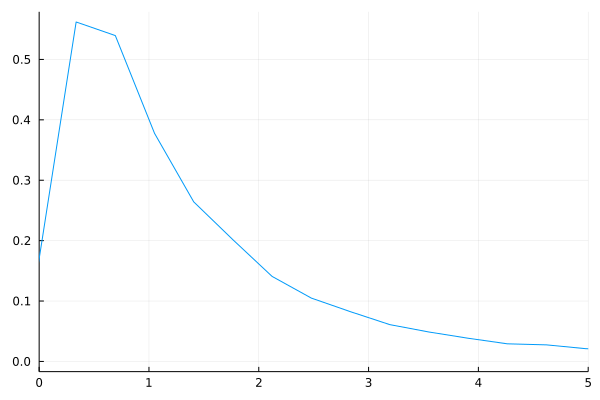

In [54]:
b = rand(LogNormal(0, 1), 10_000)
density(b, xlims=(0, 5), bandwidth=0.1)

Code 4.41

In [55]:
Random.seed!(2971)
N = 100
a = rand(Normal(178, 20), N)
b = rand(LogNormal(0, 1), N);

Code 4.42

In [56]:
d = DataFrame(CSV.File("data/Howell1.csv"));
d2 = d[d.age .>= 18,:]
xbar = mean(d2.weight)

@model function height_regr_model(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3 = sample(height_regr_model(d2.weight, d2.height), NUTS(), 1000)
m4_3 = resetrange(m4_3);

Code 4.43

In [57]:
@model function height_regr_model_exp(weight, height)
    a ~ Normal(178, 20)
    log_b ~ Normal(0, 1)
    μ = @. a + exp(log_b) * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3b = sample(height_regr_model_exp(d2.weight, d2.height), NUTS(), 1000);

Code 4.44

In [58]:
m4_3_df = DataFrame(m4_3)
precis(m4_3_df)

┌───────┬────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%   histogram │
├───────┼────────────────────────────────────────────────────────┤
│     a │ 154.606  0.2625  154.175  154.616  155.014  ▁▁▂▅██▅▂▁▁ │
│     b │  0.9014  0.0423    0.835   0.9021   0.9665      ▁▃██▃▁ │
│     σ │  5.1071  0.1978   4.8019   5.0921   5.4553     ▁▁▅█▅▂▁ │
└───────┴────────────────────────────────────────────────────────┘


Code 4.45

In [59]:
round.(cov(Matrix(m4_3_df)), digits=3)

3×3 Matrix{Float64}:
  0.069  -0.0    -0.001
 -0.0     0.002  -0.0
 -0.001  -0.0     0.039

Code 4.46

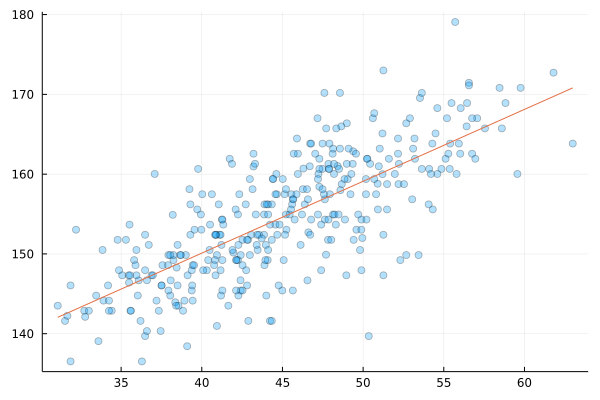

In [60]:
p = @df d2 scatter(:weight, :height; alpha=0.3)

chain = resetrange(m4_3)
samples = sample(chain, 1000)

a_map = mean(samples[:a])
b_map = mean(samples[:b])
plot!(x -> a_map + b_map*(x-xbar))

Code 4.47

In [61]:
post = sample(m4_3, 1000)
post_df = DataFrame(post)
post_df[1:5,:]

5×3 DataFrame
 Row │ a        b         σ       
     │ Float64  Float64   Float64 
─────┼────────────────────────────
   1 │ 155.241  0.939497  5.32578
   2 │ 154.435  0.890103  5.15068
   3 │ 154.393  0.95766   5.12624
   4 │ 154.644  0.975131  5.02818
   5 │ 154.719  0.833828  5.12795

Code 4.48

In [62]:
N = 10
dN = d2[1:N,:]

@model function height_regr_model_N(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    m_weight = mean(weight)
    μ = @. a + b * (weight - m_weight)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

mN = sample(height_regr_model(dN.weight, dN.height), NUTS(), 1000)
mN = resetrange(mN);

Code 4.49

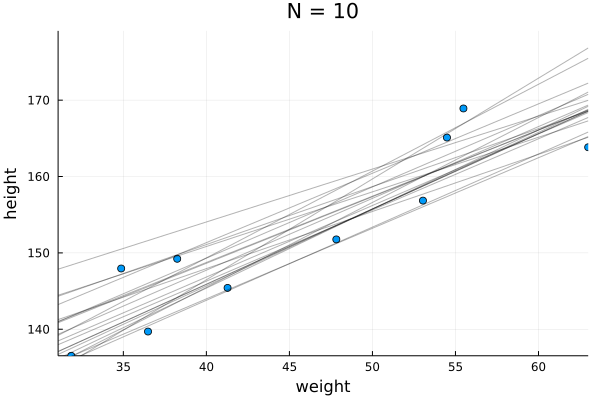

In [63]:
post = sample(mN, 20)
post_df = DataFrame(post);

xlims = extrema(d2.weight)
ylims = extrema(d2.height)
p = @df dN scatter(:weight, :height; xlims=xlims, ylims=ylims)
title!("N = $N"; xlab="weight", ylab="height")

x_mean = mean(dN.weight)
for (a, b) ∈ zip(post_df.a, post_df.b)
    plot!(x -> a + b * (x-x_mean); c="black", alpha=0.3)
end
display(p)

Code 4.50

In [64]:
post = sample(m4_3, 1000)
post_df = DataFrame(post)
μ_at_50 = @. post_df.a + post_df.b * (50 - xbar);

Code 4.51

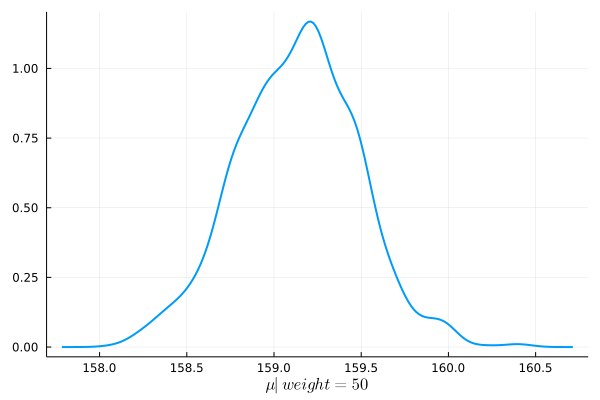

In [65]:
density(μ_at_50; lw=2, xlab=L"\mu|weight=50")

Code 4.52

In [66]:
PI(μ_at_50; prob=0.89)

2-element Vector{Float64}:
 158.5792439935818
 159.65866731906047

Code 4.53

In [67]:
μ = StatisticalRethinking.link(post_df, [:a :b], d2.weight, xbar);
μ = hcat(μ...);
Base.size(μ), μ[1:5,1]

((1000, 352), [157.56293534189655, 157.70353697789378, 156.97988672219105, 156.85965609569527, 157.2632797224988])

Code 4.54

In [68]:
weight_seq = 25:70
μ = StatisticalRethinking.link(post_df, [:a :b], weight_seq, xbar);
μ = hcat(μ...);
Base.size(μ), μ[1:5,1]

((1000, 46), [137.04072934028633, 136.64103095564798, 135.80904017330352, 136.73820023564727, 137.81265964505803])

Code 4.55

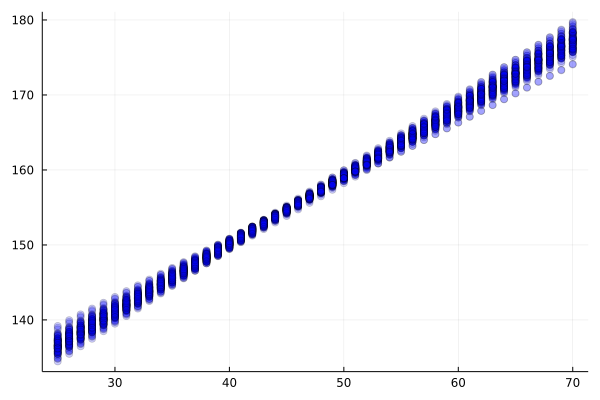

In [69]:
p = plot()
for i in 1:100
    scatter!(weight_seq, μ[i,:]; c=:blue, alpha=0.2)
end
display(p)

Code 4.56

In [70]:
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...);

Code 4.57

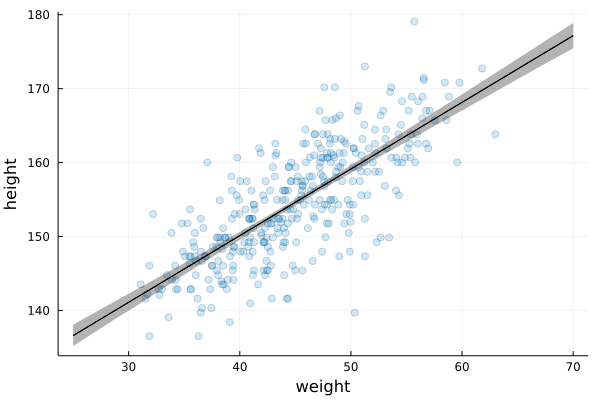

In [71]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)

Code 4.58

In [72]:
post = sample(m4_3, 1000)
post = DataFrame(post)

weight_seq = 25:70
μ = map(w -> post.a + post.b * (w - xbar), weight_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_CI = PI.(eachcol(μ));

Code 4.59

In [73]:
sim_height = simulate(post, [:a, :b, :σ], weight_seq .- xbar);
Base.size(sim_height), sim_height[1:5,1]

((1000, 46), [131.0600330744535, 131.07613382456364, 144.0054107126664, 133.0809884065339, 139.1993923582497])

Code 4.60

In [74]:
height_PI = PI.(eachcol(sim_height))
height_PI = vcat(height_PI'...);

Code 4.61

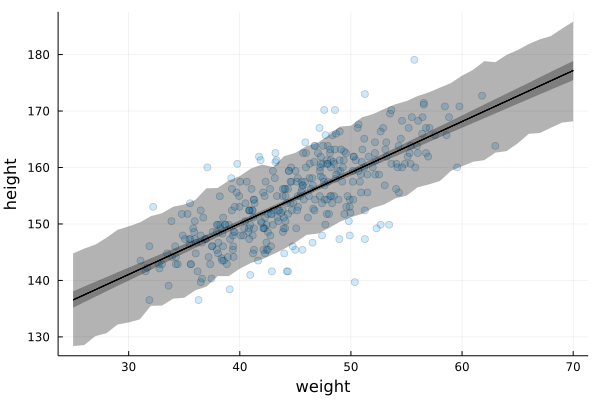

In [75]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.62

In [76]:
post = sample(m4_3, 10_000)
post = DataFrame(post)
sim_height = simulate(post, [:a, :b, :σ], weight_seq .- xbar)
height_PI = PI.(eachcol(sim_height))
height_PI = vcat(height_PI'...);

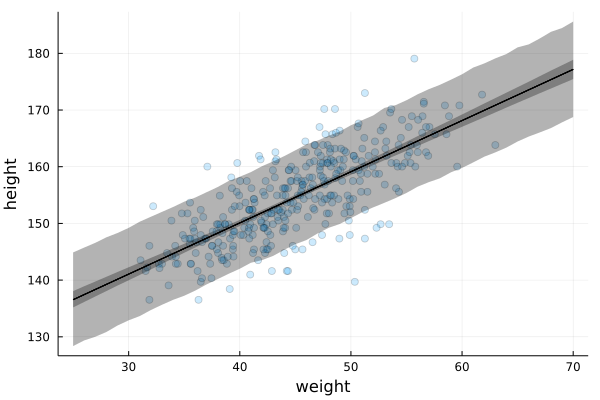

In [77]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.63

In [78]:
post = sample(m4_3, 1000)
post = DataFrame(post)

sim_height = [
    [
        rand(Normal(a + b * (w - xbar), σ))
        for (a, b, σ) ∈ zip(post.a, post.b, post.σ)
    ]
    for w ∈ weight_seq
]
sim_height = hcat(sim_height...)

height_PI = PI.(eachcol(sim_height));
height_PI = vcat(height_PI'...);

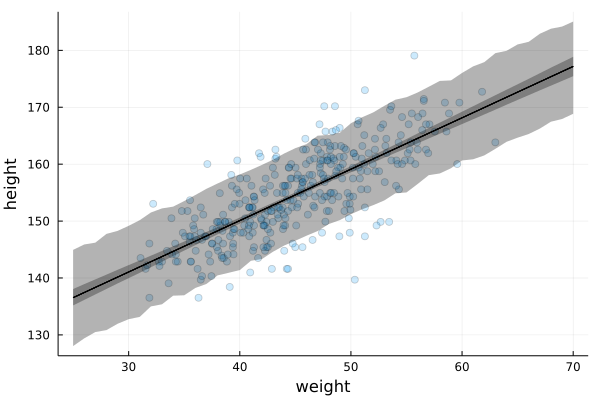

In [79]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

# 4.5 Curves from lines

Code 4.64

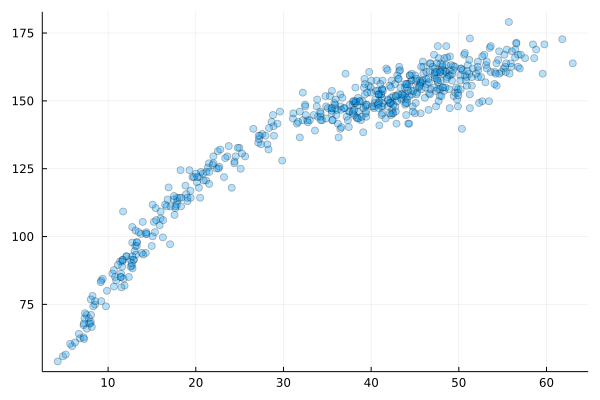

In [80]:
d = DataFrame(CSV.File("data/Howell1.csv"))
scatter(d.weight, d.height; alpha=0.3)

Code 4.65

In [81]:
d[!, :weight_s] = standardize(ZScoreTransform, d.weight)
d[!, :weight_s2] = d.weight_s.^2;

@model function height_regr_m2(weight_s, weight_s2, height)
    a ~ Normal(178, 20)
    b1 ~ LogNormal(0, 1)
    b2 ~ Normal(0, 1)
    μ = @. a + b1 * weight_s + b2 * weight_s2
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_5 = sample(height_regr_m2(d.weight_s, d.weight_s2, d.height), NUTS(), 1000)
m4_5 = resetrange(m4_5)
m4_5_df = DataFrame(m4_5);

Code 4.66

In [82]:
precis(m4_5_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ 146.054  0.3497  145.501  146.059  146.576  ▁▁▂▃▅██▇▄▂▁▁▁ │
│    b1 │ 21.7228  0.2941  21.2498  21.7259  22.1891    ▁▁▁▄▇█▇▄▂▁▁ │
│    b2 │ -7.8033  0.2589  -8.1943  -7.8236  -7.3754      ▁▁▂▄█▆▅▂▁ │
│     σ │  5.8137   0.179   5.5276   5.8055   6.1068   ▁▁▁▃▆██▆▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


Code 4.67

In [83]:
Random.seed!(1)
df = sample(m4_5_df, 1000)
weight_seq = range(-2.2, 2; length=30)

# explicit logic of link
mu = [
    df.a + df.b1 * w_s + df.b2 * w_s^2
    for w_s ∈ weight_seq
]

mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...)

# explicit logic of sim
sim_height = [
    [
        rand(Normal(row.a + row.b1 * w_s + row.b2 * w_s^2, row.σ))
        for row ∈ eachrow(df)
    ]
    for w_s ∈ weight_seq
]
sim_height = hcat(sim_height...);

height_PI = PI.(eachcol(sim_height))
height_PI = vcat(height_PI'...);

Code 4.68

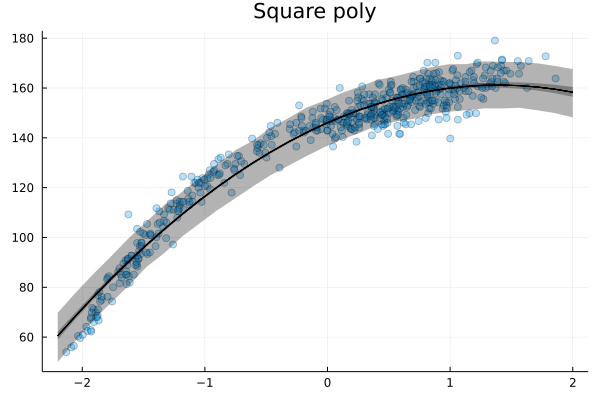

In [84]:
p_square = @df d scatter(:weight_s, :height; alpha=0.3, title="Square poly")
plot!(weight_seq, mu_mean; c=:black)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.69

In [85]:
d[!, :weight_s3] = d.weight_s.^3;

@model function height_regr_m3(weight_s, weight_s2, weight_s3, height)
    a ~ Normal(178, 20)
    b1 ~ LogNormal(0, 1)
    b2 ~ Normal(0, 1)
    b3 ~ Normal(0, 1)
    μ = @. a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_6 = sample(height_regr_m3(d.weight_s, d.weight_s2, d.weight_s3, d.height), NUTS(), 1000)
m4_6 = resetrange(m4_6)
m4_6_df = DataFrame(m4_6)
precis(m4_6_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ 146.399  0.3158  145.888  146.405  146.898    ▁▁▁▃▅██▆▃▁▁ │
│    b1 │ 15.2346  0.4765  14.4594  15.2243  15.9857       ▁▁▁▄█▅▁▁ │
│    b2 │  -6.213  0.2561  -6.6352  -6.2127  -5.8004     ▁▁▂▅██▄▂▁▁ │
│    b3 │  3.5764  0.2239   3.2084    3.584   3.9364       ▁▂▄██▃▁▁ │
│     σ │  4.8605   0.147   4.6456   4.8546   5.0868  ▁▁▁▄▇█▇▄▂▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


In [86]:
Random.seed!(1)
df = sample(m4_6_df, 1000)
weight_seq = range(-2.2, 2; length=30)

# explicit logic of link
mu = [
    df.a + df.b1 * w_s + df.b2 * w_s^2 + df.b3 * w_s^3
    for w_s ∈ weight_seq
]

mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...)

# explicit logic of sim
sim_height = [
    [
        rand(Normal(row.a + row.b1 * w_s + row.b2 * w_s^2 + row.b3 * w_s^3, row.σ))
        for row ∈ eachrow(df)
    ]
    for w_s ∈ weight_seq
]
sim_height = hcat(sim_height...);

height_PI = PI.(eachcol(sim_height))
height_PI = vcat(height_PI'...);

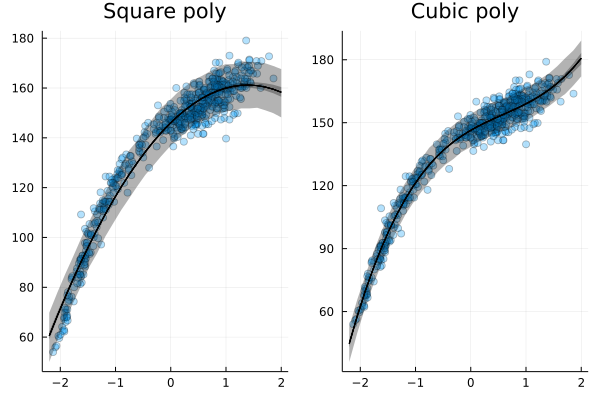

In [89]:
p_cubic = @df d scatter(:weight_s, :height; alpha=0.3, title="Cubic poly")
plot!(weight_seq, mu_mean; c=:black)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(weight_seq, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

plot(p_square, p_cubic; layout=(1, 2))

Code 4.70 and 4.71

Looks like Julia plots don't support change of ticks proposed in the book.
But much more natural way will be to remap values we're plotting back to the original scale.
Example of this is below.

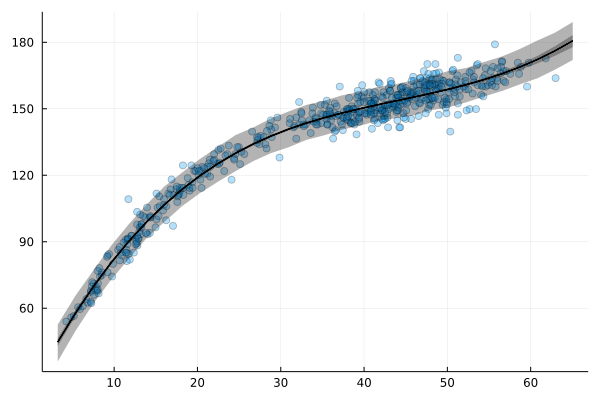

In [90]:
μ = mean(d.weight)
σ = std(d.weight)
w = @. d.weight_s * σ + μ
scatter(w, d.height; alpha=0.3)

w_s = @. weight_seq * σ + μ
plot!(w_s, mu_mean; c=:black)
plot!(w_s, [mu_mean mu_mean]; c=:black, fillrange=mu_PI, fillalpha=0.3)
plot!(w_s, [mu_mean mu_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

Code 4.72

In [91]:
d = DataFrame(CSV.File("data/cherry_blossoms.csv", missingstring="NA"))
precis(d)

┌────────────┬─────────────────────────────────────────────────────────┐
│      param │   mean      std    5.5%     50%    94.5%      histogram │
├────────────┼─────────────────────────────────────────────────────────┤
│       year │ 1408.0  350.885  867.77  1408.0  1948.23  ████████████▂ │
│        doy │ 104.54    6.407   94.43   105.0    115.0       ▁▂▆██▅▂▁ │
│       temp │ 6.1419   0.6636    5.15     6.1   7.2947       ▁▄▆█▄▂▁▁ │
│ temp_upper │ 7.1852   0.9929  5.8977    7.04   8.9023       ▂██▃▁▁▁▁ │
│ temp_lower │ 5.0989   0.8503  3.7876   5.145     6.37       ▁▁▁▂▇█▂▁ │
└────────────┴─────────────────────────────────────────────────────────┘


Code 4.73

In [92]:
d2 = d[completecases(d[!,[:doy]]),:]
d2 = disallowmissing(d2[!,[:year,:doy]])
num_knots = 15
knots_list = quantile(d2.year, range(0, 1; length=num_knots));

Code 4.74

In [93]:
using BSplines

basis = BSplineBasis(3, knots_list)

16-element BSplineBasis{Vector{Float64}}:
 order: 3
 breakpoints: [812.0, 1036.0, 1174.0, 1269.0, 1377.0, 1454.0, 1518.0, 1583.0, 1650.0, 1714.0, 1774.0, 1833.0, 1893.0, 1956.0, 2015.0]

Code 4.75

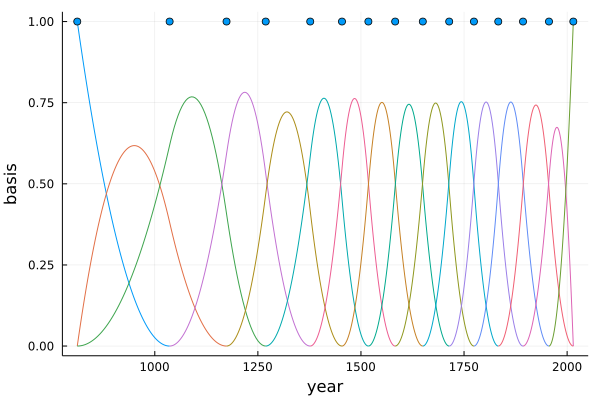

In [95]:
p1 = plot(basis)
scatter!(knots_list, repeat([1], num_knots); xlab="year", ylab="basis", legend=false)

Code 4.76

This way of calucalting bsplines is slightly slower, than shown in the book (with pre-calculated matrix) but it is much cleaner in my perspective.

You can do comparison yourself by precalculating spline matrix outside of the model and do matrix multiplication in the model instead of spline evialutaion. Example of doing this is at code block 4.79

In [96]:
@model function model_splines(year, doy)
    w ~ MvNormal(zeros(length(basis)), 1)
    a ~ Normal(100, 10)
    s = Spline(basis, w)
    μ = a .+ s.(year)
    σ ~ Exponential(1)
    doy ~ MvNormal(μ, σ)
end

m4_7 = sample(model_splines(d2.year, d2.doy), NUTS(0.65; init_ϵ = 9.765625e-5), 1000)

Chains MCMC chain (1000×30×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 13.62 seconds
Compute duration  = 13.62 seconds
parameters        = w[1], w[13], σ, w[3], w[12], w[8], w[10], w[14], w[11], w[9], w[16], a, w[2], w[4], w[6], w[5], w[7], w[15]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

        w[1]    -0.6812    0.9172     0.0290    0.0163   1813.8789    0.9991   ⋯
        w[2]    -0.8555    0.8626     0.0273    0.0187   2705.8346    0.9990   ⋯
        w[3]     0.8252    0.8027     0.0254    0.0213   1626.8872    1.0002   ⋯
        w[4]     0.6955    0.7619     0.0241  

Code 4.77

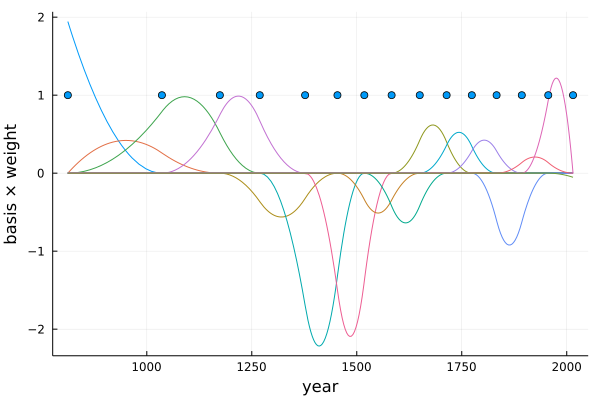

In [97]:
post = DataFrame(m4_7)

# convert columns w[*] into single column w
w_df = DataFrames.select(post, r"w")
post = DataFrames.select(post, Not(r"w"))
post[!,:w] = Vector.(eachrow(w_df))

# vector of 16 average w values
w_mean = mean.(eachcol(w_df))
p2 = plot(basis .* w_mean)
scatter!(knots_list, repeat([1], num_knots); xlab="year", ylab="basis × weight")

Code 4.78

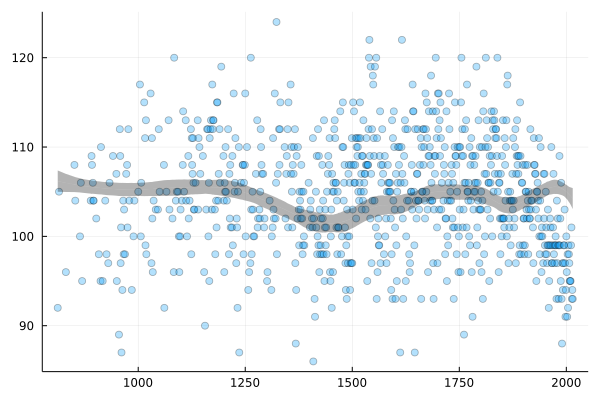

In [98]:
# explicit link logic
μ = [
    row.a .+ Spline(basis, row.w).(d2.year)
    for row ∈ eachrow(post)
]
μ = hcat(μ...);

μ_PI = PI.(eachrow(μ))
μ_PI = vcat(μ_PI'...);

p3 = @df d2 scatter(:year, :doy; alpha=0.3)
μ_mean = mean.(eachrow(μ_PI))
plot!(d2.year, [μ_mean, μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3, alpha=0)

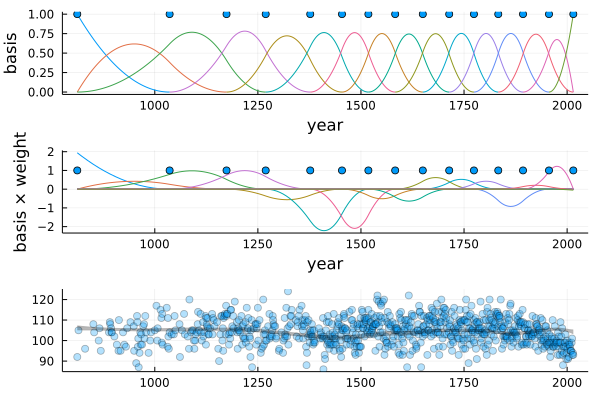

In [99]:
plot(p1, p2, p3; layout=(3, 1))

Code 4.79

How to build the model with explicit spline matrix calculation

In [100]:
basis = BSplineBasis(3, knots_list)

# list of splines with 1 only at corresponding basis index
splines = [
    Spline(basis, [float(idx == knot) for idx ∈ 1:length(basis)])
    for knot ∈ 1:length(basis)
]

# calculate each spline for every year. Resulting matrix B is 827x16
B = [
    map(s -> s(year), splines)
    for year in d2.year
]
B = vcat(B'...);


# do not need years parameter anymore, all the information is in B matrix
@model function model_splines_matrix(doy)
    w ~ MvNormal(zeros(length(basis)), 1)
    a ~ Normal(100, 10)
    μ = a .+ B * w
    σ ~ Exponential(1)
    doy ~ MvNormal(μ, σ)
end

m4_7alt = sample(model_splines_matrix(d2.doy), NUTS(0.65; init_ϵ = 0.0001953125), 1000)

Chains MCMC chain (1000×30×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.9 seconds
Compute duration  = 4.9 seconds
parameters        = w[1], w[13], σ, w[3], w[12], w[8], w[10], w[14], w[11], w[9], w[16], a, w[2], w[4], w[6], w[5], w[7], w[15]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

        w[1]    -0.6977    0.9024     0.0285    0.0185   2200.5259    0.9990   ⋯
        w[2]    -0.8587    0.8423     0.0266    0.0170   2112.9445    1.0009   ⋯
        w[3]     0.8351    0.7801     0.0247    0.0161   2085.0565    0.9990   ⋯
        w[4]     0.6791    0.6900     0.0218    0.